# Vizualizarea dataset-ului

## 1. Importuri necesare, setari

In [1]:
# required imports
import gzip
import json
import os
import re

# multi-array stuff
import pandas as pd
import numpy as np

# plot stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sea

# import and set no warnigns
import warnings
warnings.filterwarnings('ignore')

# set pd max cols / rows = 999
# pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999

## 2. Incarcare, parsare, modelare date AUTOVIT.RO

In [2]:
def strip_nr(str_nr):
    if str_nr is not None:
        return int(re.sub(r'[^0-9]+', '', str_nr))
    else:
        raise TypeError
    
def get_listing_param(data, name):
    for p in data['listing_params']:
        if p[0] == name:
            return p[1]
    else:
        return None

def get_data():
    raw_adverts = []
    for root, dirs, files in os.walk('../database/autovit/adverts/'):
        for name in files:
            file = os.path.join(root, name)
            with gzip.open(file, 'r') as fin:
                raw_adverts.extend(json.loads(fin.read().decode('utf-8')))
    print('** Total loaded adverts: {} **'.format(len(raw_adverts)))
    raw_adverts[0].pop('photos', None)
    return raw_adverts

def parse_data(raw_adverts):
    parsed_adverts = []
    for ad in raw_adverts:
        # Ad has req data, essential
        if 'list_label' in ad \
            and get_listing_param(ad, 'Anul fabricatiei') is not None \
            and get_listing_param(ad, 'Kilometraj') is not None \
            and get_listing_param(ad, 'Combustibil') is not None \
            and 'features' in ad \
            and 'params' in ad:

            # reshape params data
            if 'params' in ad:
                for p in ad['params']:
                    ad[p[0]] = p[1]
                # pop extra params
                ad.pop('params', None)

            # reshape features
            if 'features' in ad:
                for f in ad['features']:
                    ad[f] = True
                # pop extra features
                ad.pop('features', None)

            # format price as int only
            if 'list_label' in ad:
                ad['price'] = strip_nr(ad['list_label'])
                ad.pop('list_label', None)
            else:
                print('No list label')

            ad['fabrication_year'] = strip_nr(get_listing_param(ad, 'Anul fabricatiei'))
            ad['kilometers'] = strip_nr(get_listing_param(ad, 'Kilometraj'))
            ad['fuel'] = get_listing_param(ad, 'Combustibil').lower()
            ad['brand_model'] = '{}-{}'.format(ad['Marca'], ad['Model'])

            # Params
            hp = ad['Putere'] if 'Putere' in ad else None
            if hp is not None:
                hp = strip_nr(hp.replace('CP', ''))
                ad['horse_power'] = hp

            co2 = ad['Emisii CO2'] if 'Emisii CO2' in ad else None
            if co2 is not None:
                co2 = strip_nr(co2.replace('g/km', ''))
                ad['emissions'] = co2

            # Listing params
            cc = get_listing_param(ad, 'Capacitate cilindrica')
            if cc is not None:
                cc = strip_nr(cc.replace('cm3', ''))
                ad['cubic_capacity'] = cc

            # pop unused keys
            ad.pop('photos', None)
            ad.pop('description', None)

            # append to list
            parsed_adverts.append(ad)

    return parsed_adverts


adverts = parse_data(get_data())
print('** Parsed usable adverts: {} **'.format(len(adverts)))

** Total loaded adverts: 8306 **
** Parsed usable adverts: 7076 **


### Informatii despre dataset
`count`, `mean`, `min`, `max`, `std = standard deviation`

In [3]:
df = pd.DataFrame(adverts)
df.describe()

,age,highlighted,urgent,topAd,category_id,business,hide_user_ads_button,dealer_logo_in_results,dealer_logo_in_ad_page,has_phone,has_email,map_radius,map_private_radius_size,ad_featured,price,fabrication_year,kilometers,horse_power,cubic_capacity,emissions
count,7076.000000,7076.0,7076.0,7076.000000,7076.0,7076.000000,7076.0,7076.000000,7076.000000,7041.0,7076.0,7076.000000,7076.0,7076.0,7076.000000,7076.000000,7.076000e+03,6971.000000,6930.000000,4300.000000
mean,72.856416,0.0,0.0,0.029112,29.0,0.526286,0.0,0.405879,0.444460,1.0,1.0,0.044941,2.0,0.0,17453.285331,2013.341012,1.483653e+05,162.811218,1979.163348,140.655581
std,161.639753,0.0,0.0,0.168134,0.0,0.499344,0.0,0.491096,0.496941,0.0,0.0,0.207188,0.0,0.0,24438.151689,4.861911,9.915995e+04,77.720817,608.129025,42.736634
min,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,450.000000,1982.000000,1.000000e+00,2.000000,599.000000,1.000000
25%,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,5600.000000,2010.000000,7.808325e+04,110.000000,1598.000000,114.000000
50%,28.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,9999.000000,2014.000000,1.574355e+05,147.000000,1968.000000,135.000000
75%,69.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.000000,2.0,0.0,19950.000000,2017.000000,2.110000e+05,190.000000,2000.000000,159.000000
max,4039.000000,0.0,0.0,1.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,1.000000,2.0,0.0,839496.000000,2021.000000,2.690000e+06,780.000000,6749.000000,1329.000000


### Randurile si coloanele datasetului

In [4]:
df.head(5)

,id,region_id,region_name,city_id,city_name,district_id,district_name,new_used,url,preview_url,...,brand_program_id,brand_program_small_logo,Avariata,Volan pe dreapta,,Predare leasing,Plata initiala (la predare),Valoare rata lunara,Numar de rate lunare ramase,Valoare reziduala
0,7043759122,13,Timis,97411,Remetea Mare,,,used,https://www.autovit.ro/anunt/audi-a6-ID7GGTv6....,https://www.autovit.ro/i2/anunt/audi-a6-ID7GGT...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7044506685,42,Teleorman,69925,Videle,,,used,https://www.autovit.ro/anunt/audi-a4-ID7GK1Zz....,https://www.autovit.ro/i2/anunt/audi-a4-ID7GK1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7044051670,35,Dambovita,63351,Targoviste,,,used,https://www.autovit.ro/anunt/audi-a4-2-0-ID7GI...,https://www.autovit.ro/i2/anunt/audi-a4-2-0-ID...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7044056336,12,Sibiu,34907,Talmaciu,,,used,https://www.autovit.ro/anunt/volkswagen-caddy-...,https://www.autovit.ro/i2/anunt/volkswagen-cad...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7044521035,34,Valcea,89649,Ramnicu Valcea,,,used,https://www.autovit.ro/anunt/opel-corsa-1-3-ID...,https://www.autovit.ro/i2/anunt/opel-corsa-1-3...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Vizualizarea datelor categorice
Parametrii precum: `brand`, `model`, `fuel`, `body`, `doors`, `transmission`, `status`

### Pretul mediu per marca

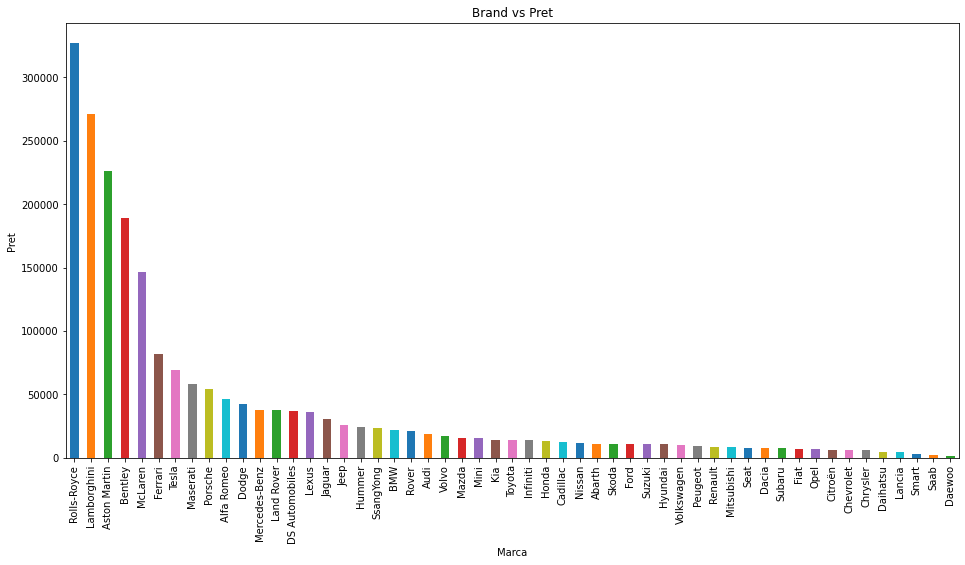

In [5]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, (1, 4))
df_brand = df.groupby(['Marca'])['price'].mean().sort_values(ascending = False)
df_brand.plot(
    title='Brand vs Pret',
    xlabel='Marca',
    ylabel='Pret',
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df['Marca'])) % plt.cm.tab10.N)
)
plt.show()

### Pretul median per Judet

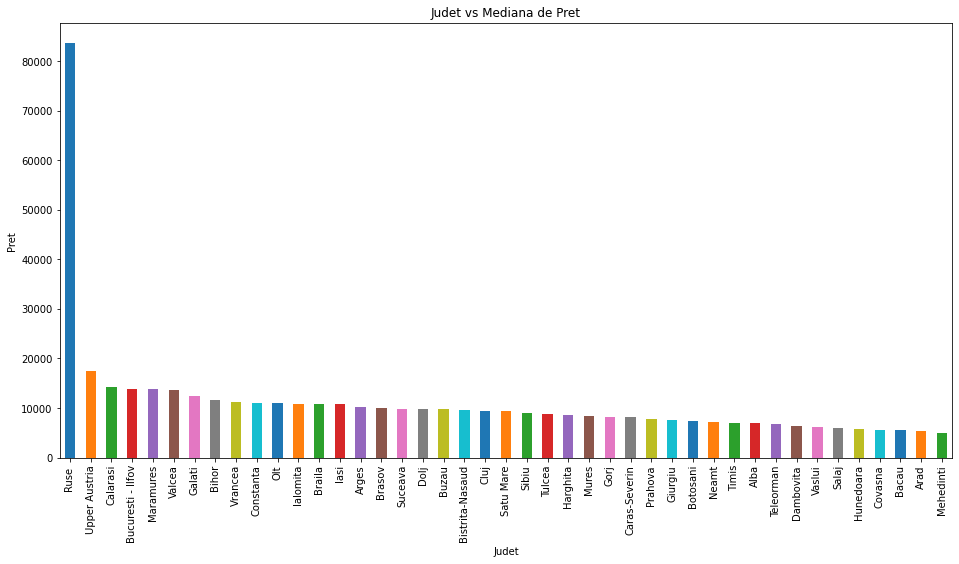

In [6]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, (1, 2))
df_cc = df.groupby(['region_name'])['price'].median().sort_values(ascending = False)
df_cc.plot(
    title='Judet vs Mediana de Pret',
    xlabel='Judet',
    ylabel='Pret',
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.region_name)) % plt.cm.tab10.N)
)
plt.show()

### Pretul mediu per tehnologie combustibil

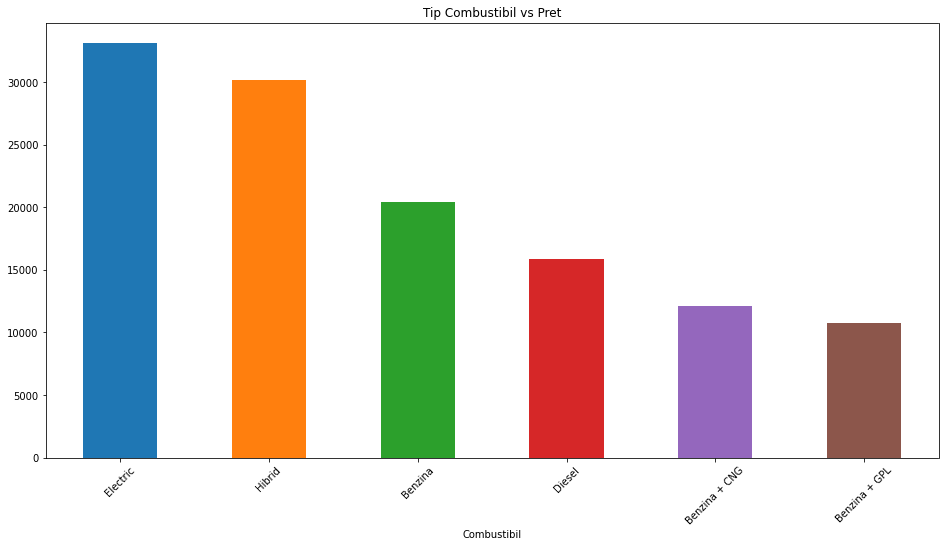

In [7]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 1, 1)
df_fuel = df.groupby(['Combustibil'])['price'].mean().sort_values(ascending = False)
df_fuel.plot(
    title='Tip Combustibil vs Pret',
    xlabel="Combustibil",
    kind="bar",
    rot=45,
    color=plt.cm.tab10(np.arange(len(df.Combustibil)) % plt.cm.tab10.N)
)
plt.show()

### Pretul mediu per modele Volkswagen

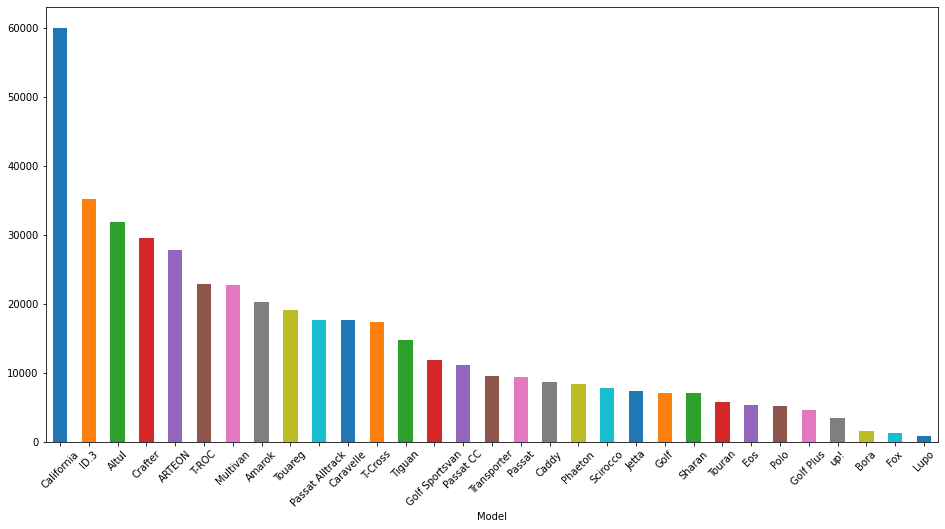

In [8]:
df_vw = df[df.Marca == 'Volkswagen']
df_vw.head()
g_vw = df_vw.groupby('Model')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(16, 8))
g_vw.plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(g_vw)) % plt.cm.tab10.N),
    rot=45
)
plt.show()

### Frecventa marca

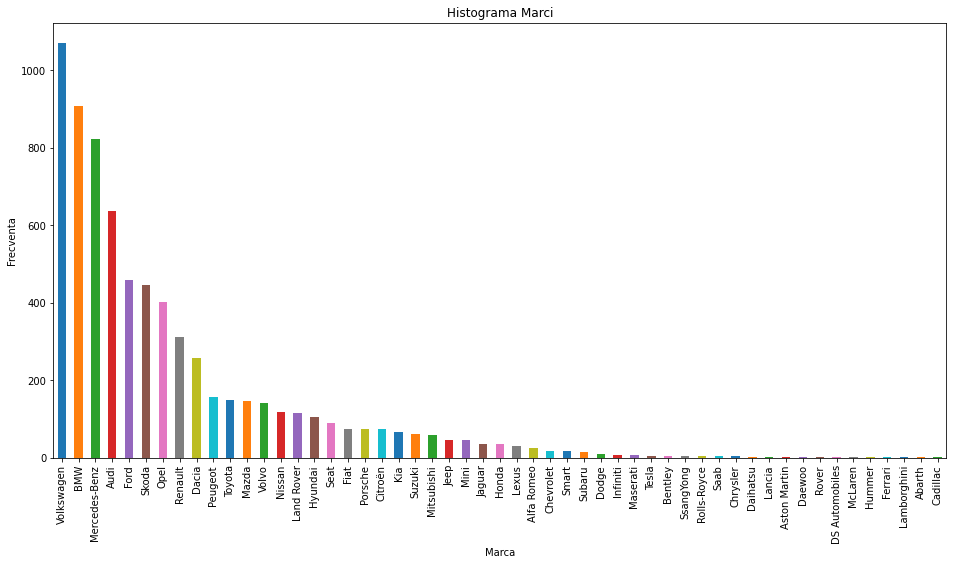

In [9]:
plt.figure(figsize=(16, 8))
df['Marca'].value_counts().plot(
    title='Histograma Marci',
    xlabel = 'Marca', 
    ylabel='Frecventa',
    kind='bar', 
    color=plt.cm.tab10(np.arange(len(df['Marca'])) % plt.cm.tab10.N)
)
plt.show()

### Frecventa combustibil

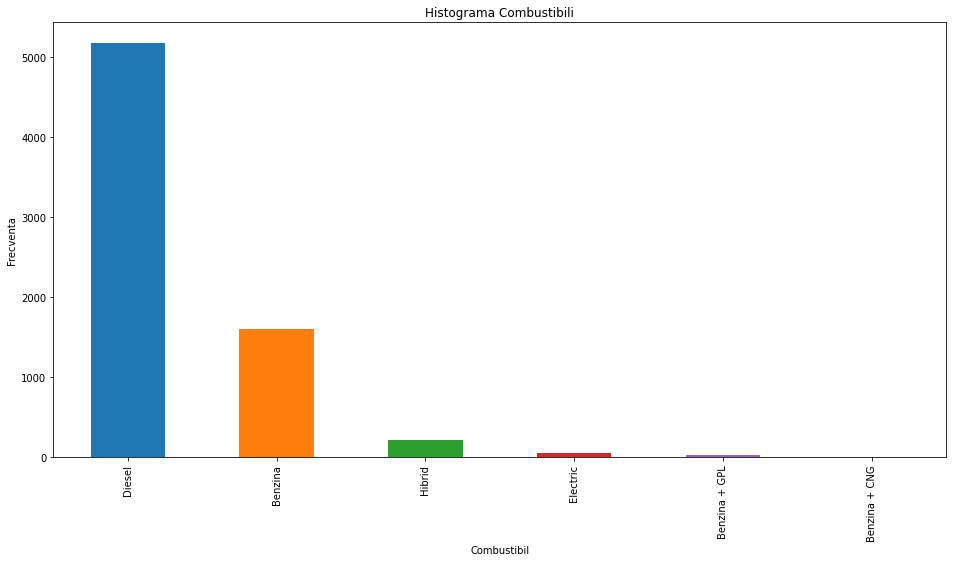

In [10]:
plt.figure(figsize=(16, 8))
df.Combustibil.value_counts().plot(
    title='Histograma Combustibili',
    xlabel = 'Combustibil', 
    ylabel='Frecventa',
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.Combustibil)) % plt.cm.tab10.N)
)
plt.show()

### Frecventa caroserie

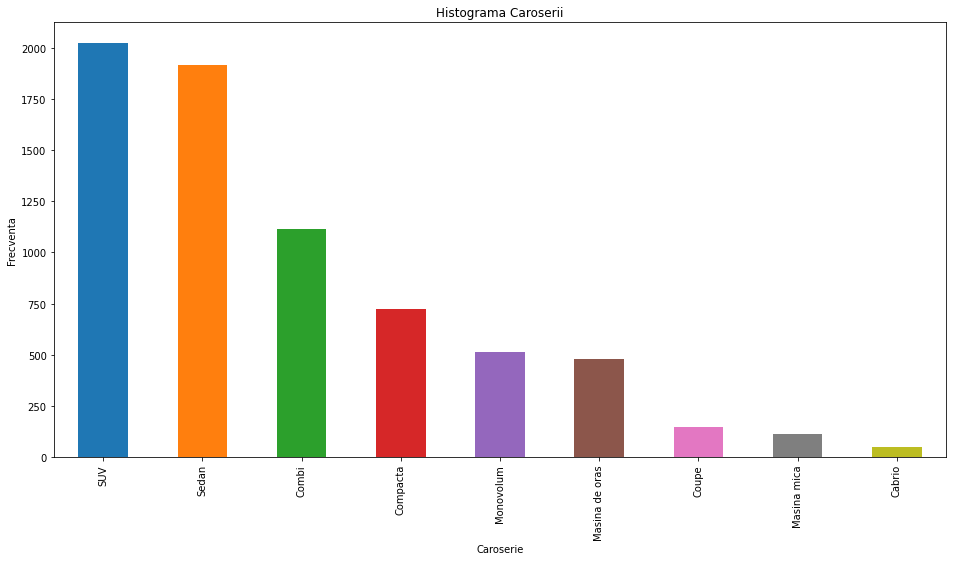

In [11]:
plt.figure(figsize=(16, 8))
df['Caroserie'].value_counts().plot(
    title='Histograma Caroserii',
    xlabel = 'Caroserie', 
    ylabel='Frecventa',
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df['Caroserie'])) % plt.cm.tab10.N)
)
plt.show()

### Frecventa an fabricare

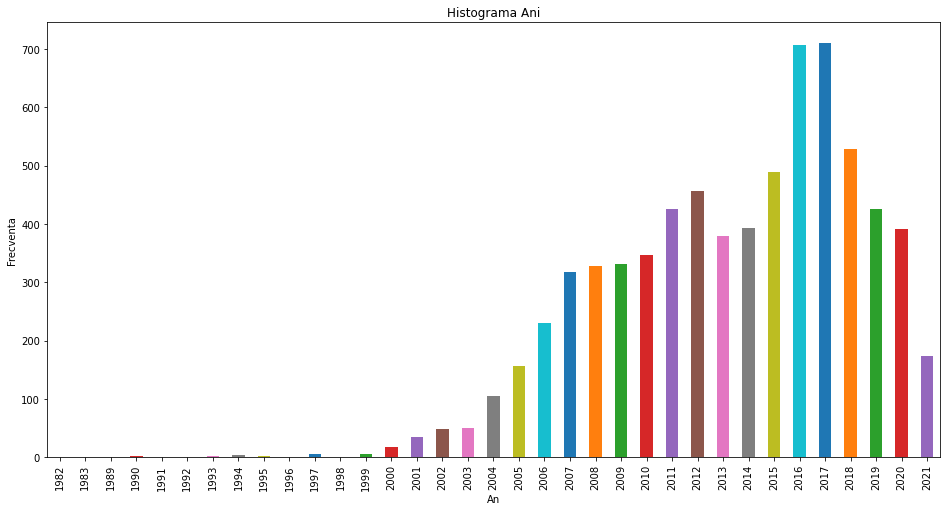

In [12]:
plt.figure(figsize=(16, 8))
df.fabrication_year.value_counts().sort_index().plot(
    title='Histograma Ani',
    xlabel = 'An', 
    ylabel='Frecventa',
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.fabrication_year)) % plt.cm.tab10.N)
)
plt.show()

## 4. Stergerea anomaliilor, vizulalizarea datelor numerice

In [13]:
def remove_outliers(x):
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = Q3 - Q1 # IQR is interquartile range. 
    filter = (df[x] >= Q1 - 1.5 * IQR) & (df[x] <= Q3 + 1.5 * IQR)
    return df.loc[filter]  

def scatter(x, fig):
    plt.subplot(2, 2, fig)
    plt.scatter(df[x], df['price'])
    plt.title(x + ' vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)

def boxplot(x, fig):
    plt.subplot(2, 2, fig)
    sea.boxplot(df[x])
    plt.title(x)
    plt.xlabel(x)
    
def distplot(x, fig):
    plt.subplot(2, 2, fig)
    sea.distplot(df[x])
    plt.title(x)
    plt.xlabel(x)
    
# Filter outliers
df = remove_outliers('price')
df = remove_outliers('kilometers')
df = remove_outliers('fabrication_year')
df = remove_outliers('cubic_capacity')
df = remove_outliers('horse_power')
df = remove_outliers('emissions')

### Distributie An Fabricare + Kilometri

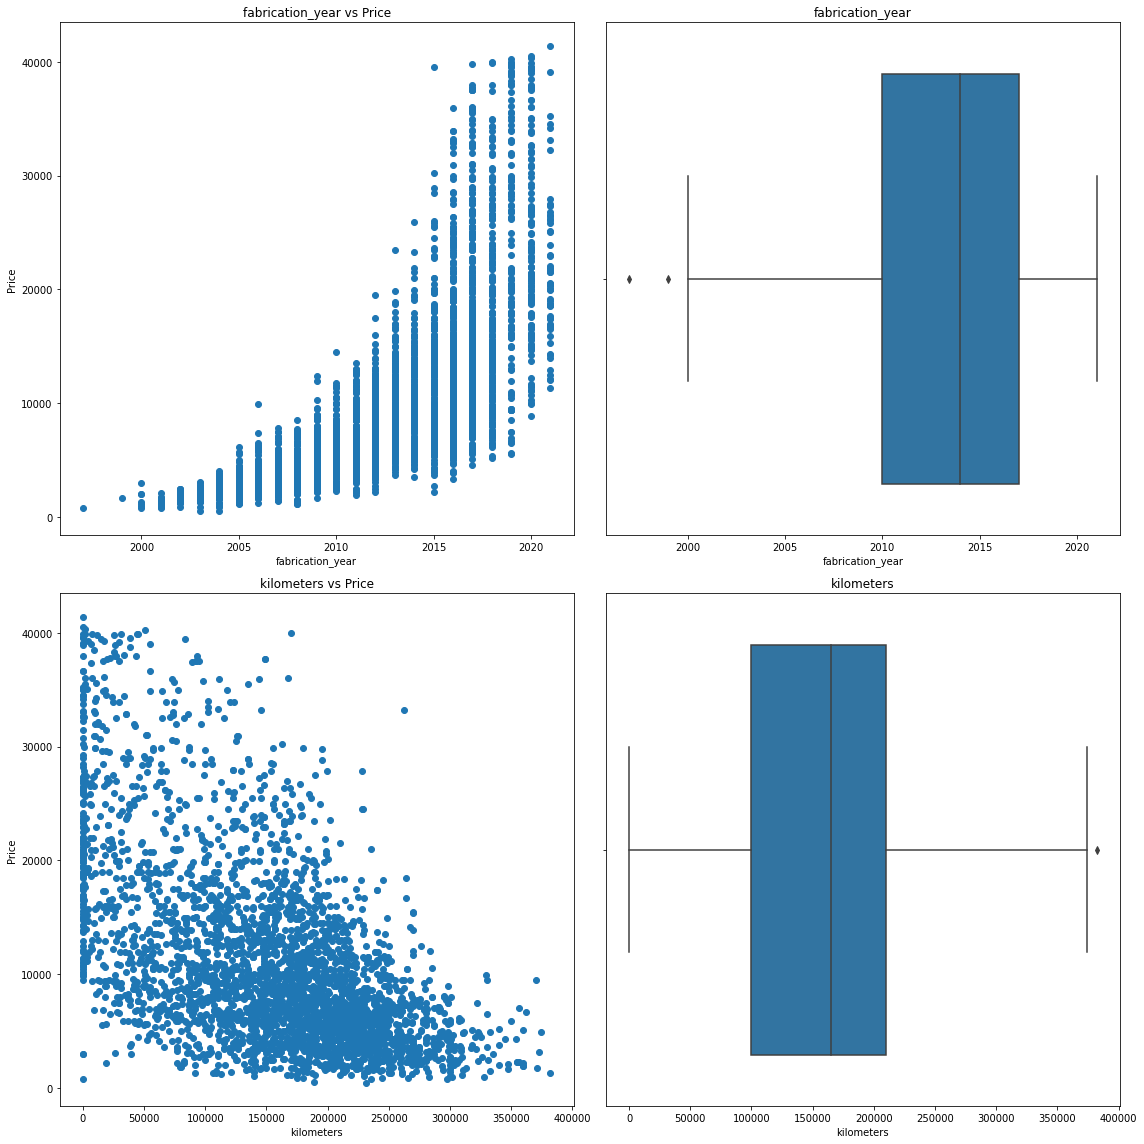

In [14]:
plt.figure(figsize=(16, 16))
scatter('fabrication_year', 1)
boxplot('fabrication_year', 2)
scatter('kilometers', 3)
boxplot('kilometers', 4)
plt.tight_layout()

### Distributie CC + CP 

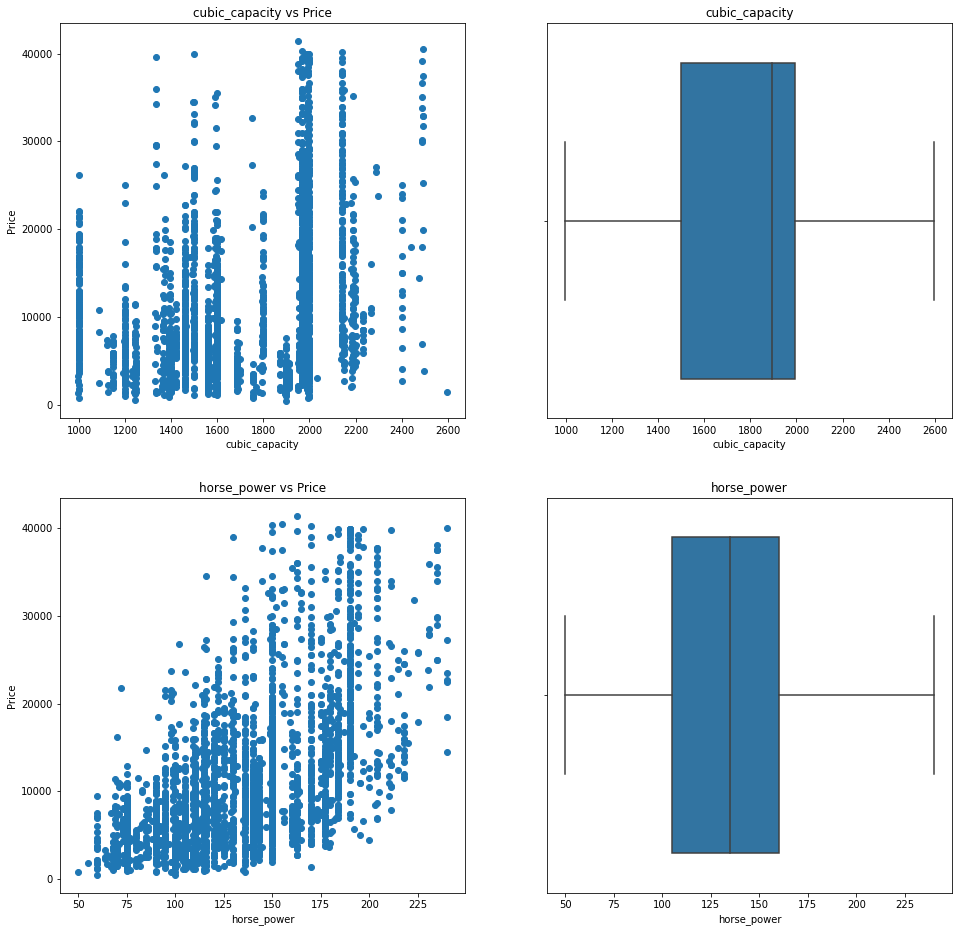

In [15]:
plt.figure(figsize=(16, 16))
scatter('cubic_capacity', 1)
boxplot('cubic_capacity', 2)
scatter('horse_power', 3)
boxplot('horse_power', 4)

### Distributia emisiilor CO2

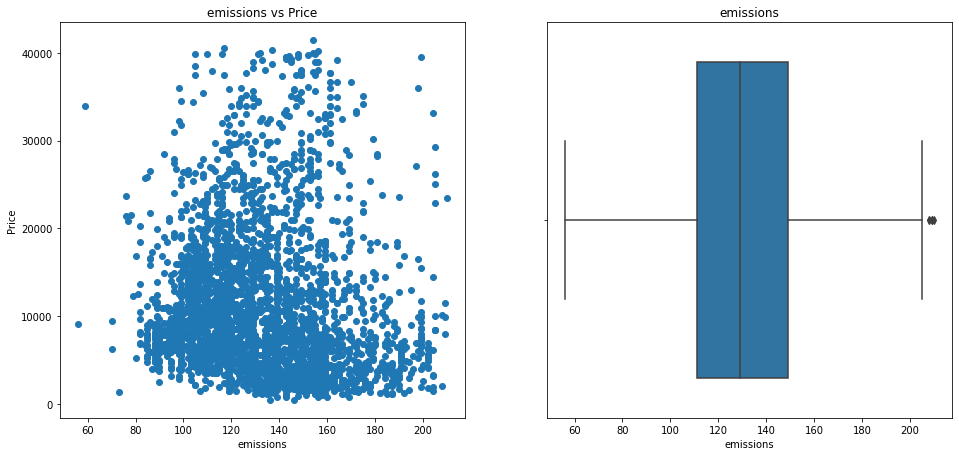

In [16]:
plt.figure(figsize=(16, 16))

scatter('emissions', 1)
boxplot('emissions', 2)

### Distributia preturilor

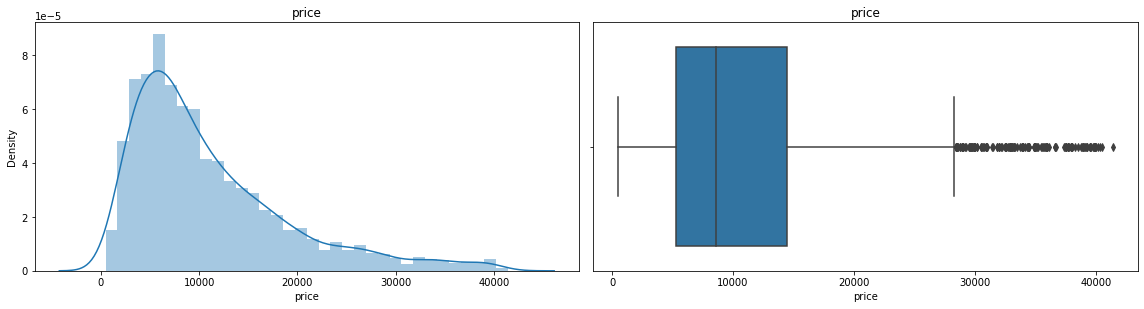

In [17]:
plt.figure(figsize=(16, 8))
distplot('price', 1)
boxplot('price', 2)
plt.tight_layout()

### Anunturi in dataset dupa parsare / filtrare valori din afara IQR

In [18]:
df['id'].size

3476

### Coeficientul de corelare intre 'An Fabricare' vs 'Kilometri'

In [19]:
np.corrcoef(df['fabrication_year'], df['kilometers'])[0, 1]

-0.655069682181696

### Analiza bivariata: 'An Fabricare' vs 'Kilometri'

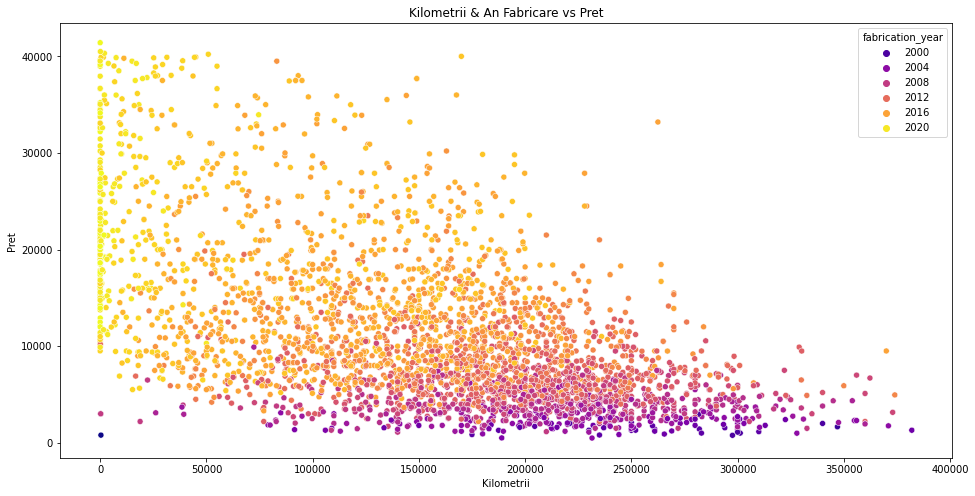

In [20]:
plt.figure(figsize=(16, 8))
plt.title('Kilometrii & An Fabricare vs Pret')
sea.scatterplot(x=df['kilometers'], y=df['price'], hue=df['fabrication_year'], palette=plt.cm.plasma)
plt.xlabel('Kilometrii')
plt.ylabel('Pret')

plt.show()

## 5. Concluzie

### Parametrii semnificativi (analiza vizuala):

- [x] price
- [x] ```'{}_{}'.format(brand, model)```
- [x] fuel 
- [x] body
- [x] kilometers (coef. negativ, relatie inversa)
- [x] horse_power
- [x] fabrication_year